# **Garbage Classification**

Dataset ini berisi 12 kelas dan terdiri dari 15,150 gambar. Source dataset berasal dari Kaggle: [Garbage Classification (12 classes)](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)

Project by Arya Setiawan

# Import Library

In [1]:
import kagglehub
import numpy as np
import os
import cv2
import shutil
from PIL import Image
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Library untuk preprocess gambar
from tensorflow.keras.utils import image_dataset_from_directory
from skimage.transform import AffineTransform, warp, rotate
from skimage.exposure import adjust_gamma
from skimage import img_as_ubyte

# Library pembangunan model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import torch

if torch.cuda.is_available():
    print('GPU tersedia')
else:
    print('GPU tidak tersedia, beralih menggunakan CPU')

GPU tersedia


# Load Dataset

### Load dataset dari Kaggle

In [3]:

# Load dataset dari Kaggle
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1


In [4]:
os.listdir(f"{path}/garbage_classification")

['biological',
 'battery',
 'shoes',
 'trash',
 'plastic',
 'paper',
 'clothes',
 'brown-glass',
 'white-glass',
 'cardboard',
 'green-glass',
 'metal']

In [5]:
path = f"{path}/garbage_classification"

# Eksplorasi Dataset

### Melihat 5 contoh gambar pada dataset

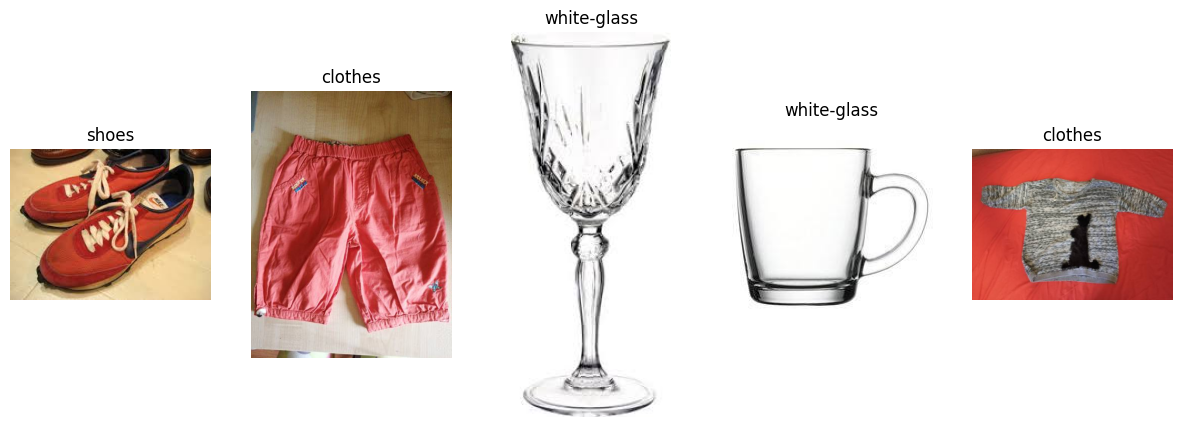

In [6]:
# Mengambil kategori
categories = os.listdir(path)

# Memasukkan path dan label gambar pada setiap kategori
image_paths = []
labels = []
for category in categories:
  category_path = os.path.join(path, category)
  if os.path.isdir(category_path):
    for img in os.listdir(category_path):
      image_paths.append(os.path.join(category_path, img))
      labels.append(category)

# Mengenerate 5 index secara acak untuk gambar yang ingin ditampilkan
sample_indices = random.sample(range(len(image_paths)), 5)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    img = mpimg.imread(image_paths[idx])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis('off')
plt.show()

**Insight**

Gambar yang ada pada dataset ini memiliki ukuran yang tidak sama sehingga perlu disesuaikan ukurannya.

### Melihat distribusi setiap kelas

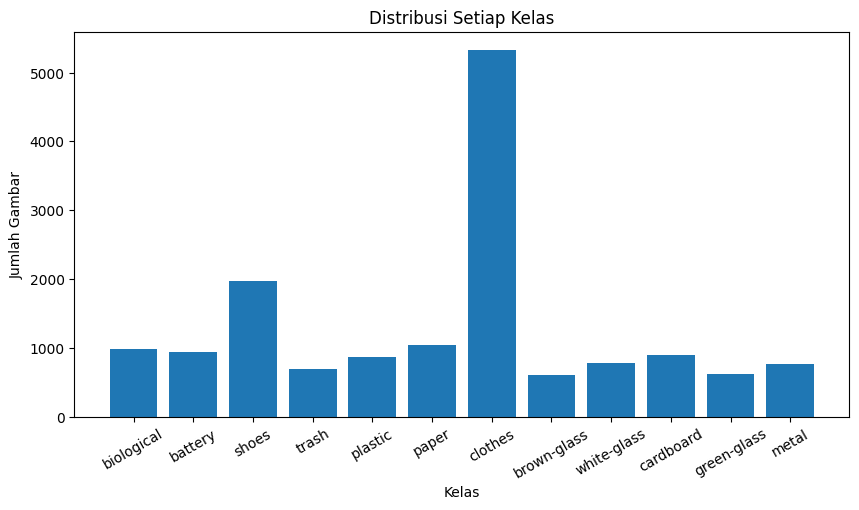

In [7]:
class_counts = {}
for category in os.listdir(path):
  category_path = os.path.join(path, category)
  if os.path.isdir(category_path):
    class_counts[category] = len(os.listdir(category_path))

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Setiap Kelas')
plt.xticks(rotation=30)
plt.show()

**Insight**

Distribusi gambar pada setiap kelas tidak terlalu seimbang khususnya pada kelas `rainbow` sehingga perlu penangan untuk menyeimbangkan distribusi gambar.

# Data Augmentation

In [8]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [9]:
transformations = {
  'rotate anticlockwise': anticlockwise_rotation,
  'rotate clockwise': clockwise_rotation,
  'warp shift': warp_shift,
  'blurring image': blur_image,
  'add brightness': add_brightness,
  'flip up down': flip_up_down,
  'shear image': sheared
}

augmented_dir = "dataset_augmented"

if os.path.exists(augmented_dir):
  print('✅ Dataset sudah diproses sebelumnya.')
else:
  # Menyediakan folder dataset augmented
  os.makedirs(augmented_dir, exist_ok=True)

  # Mengambil kelas minoritas
  minority_classes = [cls for cls, count in class_counts.items() if count < 5000]

  # Target gambar per kelas
  target_num = 4500

  for cls in class_counts:
    # Membuat folder setiap kelas di folder augmemted
    src_dir = os.path.join(path, cls)
    dst_dir = os.path.join(augmented_dir, cls)
    os.makedirs(dst_dir, exist_ok=True)

    # Mengambil gambar dan menghitung jumlahnya
    img_files = os.listdir(src_dir)
    existing = len(img_files)


    if cls in minority_classes:
      n_to_generate = target_num - existing
      print(f"Augmentasi '{cls}': {existing} gambar → tambah {n_to_generate} gambar")

      # Mencopy gambar dari folder utama ke augmented
      for image in img_files:
        shutil.copy(os.path.join(src_dir, image), os.path.join(dst_dir, image))

      # Melakukan augmentasi sesuai dengan jumlah yang ditentukan
      for i in range(n_to_generate):
        # Mengambil gambar secara random
        img_name = random.choice(img_files)
        img_path = os.path.join(src_dir, img_name)
        img = cv2.imread(img_path)

        # Mengambil metode transformasi secara random
        transform_name, transform_fn = random.choice(list(transformations.items()))
        aug_img = transform_fn(img)

        # Menyimpan gambar augmented
        aug_img = img_as_ubyte(aug_img)
        save_path = os.path.join(dst_dir, f"aug_{i}_{transform_name}.jpg")
        cv2.imwrite(save_path, aug_img)

    else:
      print(f"Menyalin '{cls}' ({existing} gambar, tanpa augmentasi)")
      for image in img_files:
        shutil.copy(os.path.join(src_dir, image), os.path.join(dst_dir, image))

  print("✅ Semua kelas telah diproses dan disimpan ke folder 'dataset_augmented'")


✅ Dataset sudah diproses sebelumnya.


### Melihat distribusi setelah augmentasi data

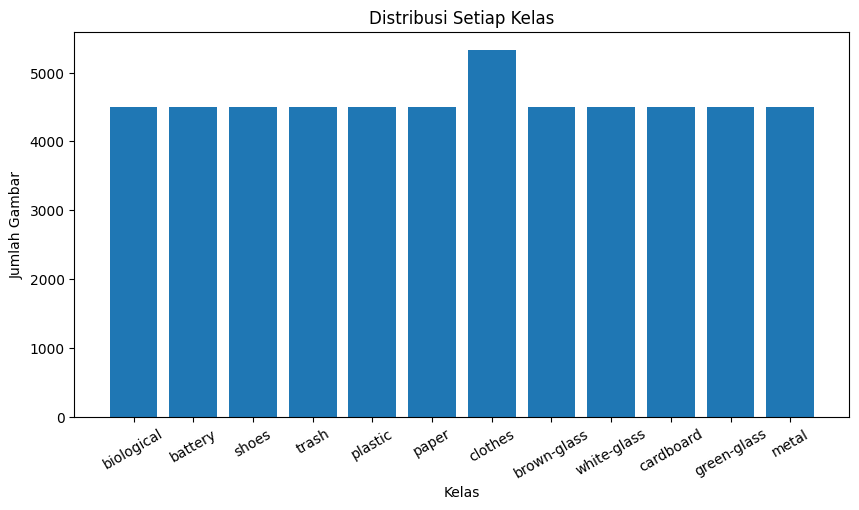

In [10]:
class_counts = {}
for category in os.listdir(augmented_dir):
  category_path = os.path.join(augmented_dir, category)
  if os.path.isdir(category_path):
    class_counts[category] = len(os.listdir(category_path))

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Setiap Kelas')
plt.xticks(rotation=30)
plt.show()

# Split Dataset

### Inisialisasi parameter yang akan digunakan

In [11]:
# Inisialisasi Parameter
data_dir = "dataset_augmented"

img_height, img_width = 128, 128
batch_size = 32
seed = 42

### Membagi dataset menjadi train, val, dan test

In [12]:
# Load dataset dan split menjadi train dan validation
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Split sebagian validation jadi test
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
test_size = val_batches // 2

test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)


Found 54825 files belonging to 12 classes.
Using 43860 files for training.
Found 54825 files belonging to 12 classes.
Using 10965 files for validation.


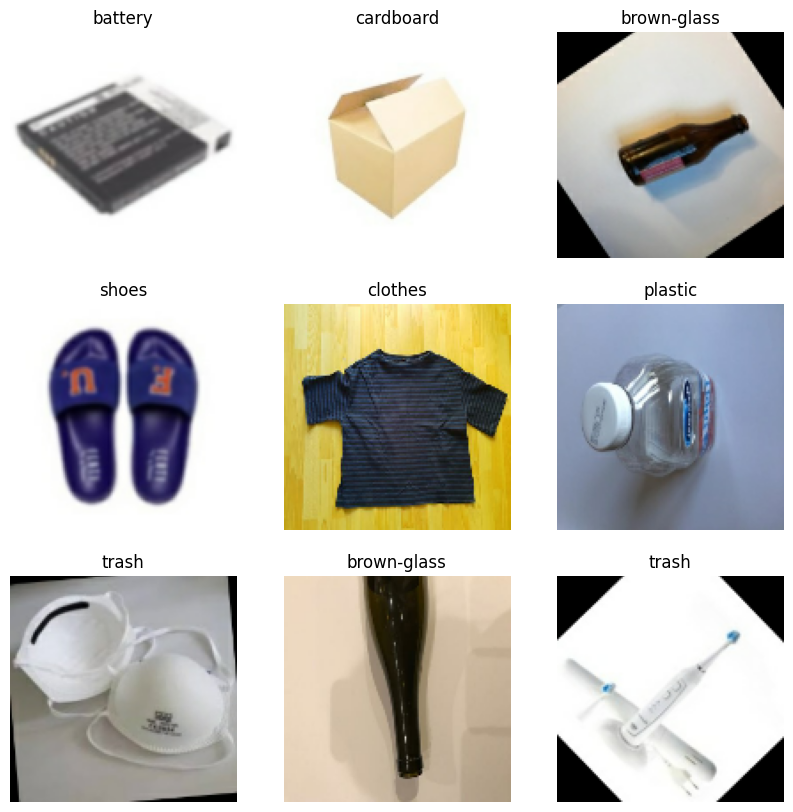

In [13]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


# Membangun Model

### Menyiapkan data

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Membuat model CNN dengan MobileNetV2

In [16]:
num_classes = len(class_names)

mobile_net = tf.keras.applications.MobileNetV2(
  include_top=False,
  weights='imagenet',
  input_shape=(img_height, img_width, 3)
)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    mobile_net,

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 4, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,029,772 (11.56 MB)

 Trainable params: 2,995,660 (11.43 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Inisialisasi callback early stopping

In [17]:
callbacks = [
    # Hentikan jika val_loss tidak membaik dalam 7 epoch
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    # Kurangi learning rate jika val_loss stagnan
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

### Training model

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 184s 89ms/step - accuracy: 0.6567 - loss: 1.1130 - val_accuracy: 0.8589 - val_loss: 0.4616 - learning_rate: 1.0000e-04
Epoch 2/10
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 70s 50ms/step - accuracy: 0.9126 - loss: 0.2963 - val_accuracy: 0.9459 - val_loss: 0.1825 - learning_rate: 1.0000e-04
Epoch 3/10
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - accuracy: 0.9452 - loss: 0.1847 - val_accuracy: 0.9456 - val_loss: 0.1713 - learning_rate: 1.0000e-04
Epoch 4/10
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.9570 - loss: 0.1470 - val_accuracy: 0.9317 - val_loss: 0.2417 - learning_rate: 1.0000e-04
Epoch 5/10
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 70s 50ms/step - accuracy: 0.9681 - loss: 0.1093 - val_accuracy: 0.9496 - val_loss: 0.1870 - learning_rate: 1.0000e-04
Epoch 6/10
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - accuracy: 0.9742 - loss: 0.0918 - val_accuracy: 0.9518 - val_loss: 0.1896 - learning_rate: 1.0000e-04
Epoch 7/10
1371/1371 ━━━━━━━━━━━━━━━━━━

### Evaluasi Model

In [19]:
train_loss, train_acc = model.evaluate(train_ds)
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Akurasi pada train set: {train_acc:.4f}")
print(f"✅ Akurasi pada test set: {test_acc:.4f}")

1371/1371 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9978 - loss: 0.0061
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9813 - loss: 0.0683
✅ Akurasi pada train set: 0.9985
✅ Akurasi pada test set: 0.9832


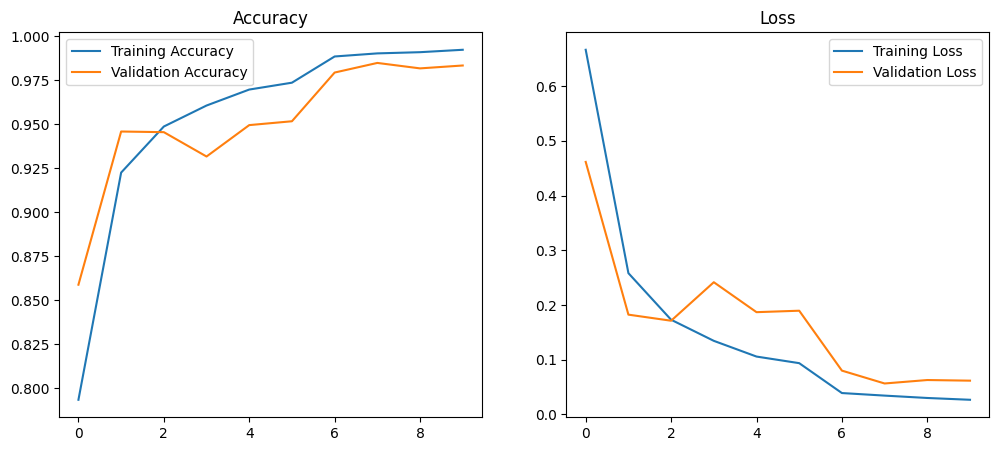

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Menyimpan Model

In [21]:
model.save("garbage-classification.h5")

### Menyimpan dalam format TFJS

In [22]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras garbage-classification.h5 tfjs_model

2025-11-12 05:35:58.145151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762925758.166260   11640 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762925758.172362   11640 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762925758.187547   11640 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762925758.187572   11640 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762925758.187575   11640 computation_placer.cc:177] computation placer alr

### Menyimpan dalam format SavedModel

In [23]:
model.export("saved_model/")

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  132875726338192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875726338960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875726333392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875726339920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875726338384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875726338576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875691901968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875691902928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875691902544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875691901008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1328756919012

### Menyimpan dalam format TF-Lite

In [24]:
tflite_dir = "tflite"
os.makedirs(tflite_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

In [25]:
# Menyimpan model pada folder
tflite_model_path = os.path.join(tflite_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

In [26]:
# Menyimpan label
with open(os.path.join(tflite_dir, "label.txt"), "w") as f:
    f.write("\n".join(class_names))

# Inference Model

In [27]:
# Path ke file model TFLite
tflite_model_path = "tflite/model.tflite"

# Load interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


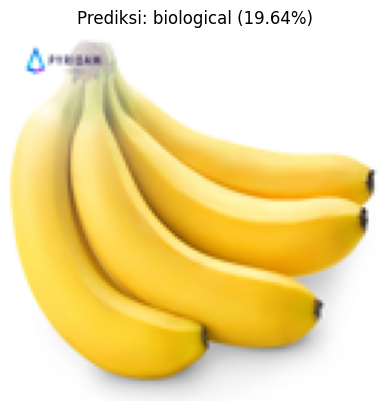

In [28]:
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

img = Image.open("/content/Sumber-energi-untuk-tubuh-ini-5-manfaat-pisang.jpg").resize((img_height, img_width))
img_array = np.array(img, dtype=np.float32)
img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

predictions_lite = interpreter.get_tensor(output_details[0]['index'])
score_lite = tf.nn.softmax(predictions_lite)

pred_label = class_names[np.argmax(score_lite)]
confidence = 100 * np.max(score_lite)


plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {pred_label} ({confidence:.2f}%)")
plt.show()

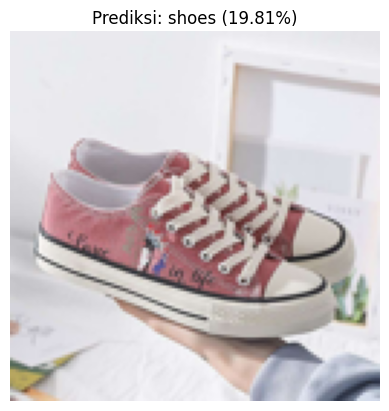

In [29]:
# Test kedua
img = Image.open("/content/brd-44261_mivaso-ambigo-sepatu-sneaker-wanita-sneaker-cute-glow-lil05-running-shoes-sepatu-wanita-fashion-import_full01-b74700cc.jpg").resize((img_height, img_width))
img_array = np.array(img, dtype=np.float32)
img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

predictions_lite = interpreter.get_tensor(output_details[0]['index'])
score_lite = tf.nn.softmax(predictions_lite)

pred_label = class_names[np.argmax(score_lite)]
confidence = 100 * np.max(score_lite)


plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {pred_label} ({confidence:.2f}%)")
plt.show()

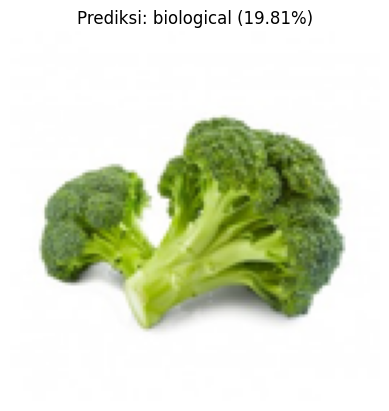

In [30]:
# Test ketiga
img = Image.open("/content/broccoli-.jpg").resize((img_height, img_width))
img_array = np.array(img, dtype=np.float32)
img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

predictions_lite = interpreter.get_tensor(output_details[0]['index'])
score_lite = tf.nn.softmax(predictions_lite)

pred_label = class_names[np.argmax(score_lite)]
confidence = 100 * np.max(score_lite)


plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {pred_label} ({confidence:.2f}%)")
plt.show()